# Stimulation Sequence Overview Figure

## Setup

### Package Imports

In [1]:
# base and metaprogramming imports
from __future__ import annotations

import datetime
import os
import shutil
import sys
import itertools as it
import pprint as pp
from typing import Optional
import warnings
import glob
import copy
import functools as ft

# analysis imports
import h5py
import numpy as np
import pandas as pd
import pandas
import yaml
from pandas.api.types import CategoricalDtype
import scipy
import scipy.ndimage
import skimage as ski
from tifffile.tifffile import imwrite

import ants
try:
    ants.from_numpy
except Exception:
    warnings.warn(f'`ants` module import failed.')
    ants = None
else:
    print('`ants` installed and imported successfully.')

# visualization and plotting imports
import napari
import napari.settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# caiman imports
import bokeh.plotting as bpl
import cv2
try:
    cv2.setNumThreads(0)
except Exception:
    pass
import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.source_extraction.cnmf import params as params
from caiman.utils.utils import download_demo
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
bpl.output_notebook()

# ipynb-specific imports
try:
    import ipynbname
except Exception as e:
    warnings.warn(f'`ipynbname` module import failed with error: {e!r}')
    ipynbname = None
    
if ipynbname is not None:
    _file = ipynbname.path()
else:
    # manually set the full path to the current notebook below if `ipynbname` 
    # import fails
    raise RuntimeError('`ipynbname` import failed. Please set the `_file`'
                       'variable manually.')
    _file = ''
    
jobs_dir = os.path.split(_file)[0]
sources_dir = os.path.abspath(os.path.join(jobs_dir, '..'))
repo_dir = os.path.abspath(os.path.join(sources_dir, '..'))
config_dir = os.path.abspath(os.path.join(repo_dir, 'configs'))

# add sources directory to path
if sources_dir not in sys.path:
    sys.path.append(sources_dir)

# local imports
import c_swain_python_utils as csutils
from utilities import *
import imaging_dataset as imd
import prairie_view_imports as pvi

_basename = os.path.basename(_file)
_name = csutils.no_ext_basename(_file)

`ants` installed and imported successfully.


Loading BokehJS ...

### Plotting Defaults

In [2]:
# plotting defaults
mpl.font_manager.fontManager.addfont('C:\\Windows\\Fonts\\Linotype - HelveticaLTPro-Black.otf')
mpl.font_manager.fontManager.addfont('C:\\Windows\\Fonts\\Linotype - HelveticaLTPro-Bold.otf')
mpl.font_manager.fontManager.addfont('C:\\Windows\\Fonts\\Linotype - HelveticaLTPro-Roman.otf')
sns.set_style(
    'ticks',
    {'font.sans-serif': ['Helvetica LT Pro', ],
     'mathtext.fontset': ['cm',],
     'axes.linewidth': 2,
     }
)
axes_lw = 2
mpl.rcParams['axes.linewidth'] = axes_lw
mpl.rcParams['xtick.major.width'] = axes_lw
mpl.rcParams['xtick.minor.width'] = axes_lw
mpl.rcParams['ytick.major.width'] = axes_lw
mpl.rcParams['ytick.minor.width'] = axes_lw
mpl.rcParams['axes.facecolor'] = 'none'
mpl.rcParams['figure.frameon'] = False
mpl.rcParams['figure.facecolor'] = 'none'
mpl.rcParams['figure.edgecolor'] = 'none'

### Logging Setup

In [3]:
# logging setup
log = csutils.get_logger(_name)

debug_mode = False
default_window_level = 'debug'

log_path = os.path.join(sources_dir, '..', 'logs', f'{_basename}.log')
csutils.apply_standard_logging_config(
    file_path=log_path,
    window_level='debug' if debug_mode else default_window_level,
    window_format='debug' if debug_mode else 'default')

### Load the Configs and Dataset Infos

In [4]:
config_fname_list = [
    'cs-ii-31_config.yml',
    'cs-ii-29_config.yml',
    'cs-ii-33_config.yml',
    'cs-ii-34_config.yml']

config_list: list[ZMIAConfig] = []
for config_fname in config_fname_list:
    config_list.append(
        ZMIAConfig(os.path.join(config_dir, config_fname))) 
    
    if config_list[-1].output_directory:
        csutils.touchdir(config_list[-1].output_directory)

all_dataset_infos = sum([c.dataset_list for c in config_list], [])

all_stim_config_dsis = [
    di for di in all_dataset_infos                    
    if (di.type == 'stimulation-config' and di.run_id is not None)]

num_matched_datasets = len(all_stim_config_dsis)
log.info('Matched {:d} live stim config dataset(s).', 
         num_matched_datasets)

local-nb_cs-ii-31_stim_sequences (  22): INFO : Matched 25 live stim config dataset(s).


#### Get the Unique Simulation Configs and their Run Ids

In [5]:
stim_config_dsi_dict = dict()
misc_metadata_dict = dict()

EXPERIMENT_ID_CN = 'experiment_id'
RUN_ID_CN = 'run_id'
STIM_CONFIG_INDEX_KEY = 'stim_config_index'

count = 0
for dsi in all_stim_config_dsis:
    full_path = dsi.full_path
    if full_path in misc_metadata_dict:
        continue
    misc_metadata_dict[full_path] = {
        EXPERIMENT_ID_CN: dsi.data['experiment-id'], 
        RUN_ID_CN: dsi.run_id,
        STIM_CONFIG_INDEX_KEY: count,
    }
    stim_config_dsi_dict[full_path] = dsi
    count += 1
    
log.info('Found {:d} unique stimulation configs.', count)

local-nb_cs-ii-31_stim_sequences (  21): INFO : Found 10 unique stimulation configs.


#### Get Associated Manifold Configs and Stim Logs

In [6]:
manifold_config_dsi_dict = dict()
stim_log_dsi_dict = dict()
for full_path, misc_metadata in misc_metadata_dict.items():
    run_id = misc_metadata[RUN_ID_CN]
    experiment_id = misc_metadata[EXPERIMENT_ID_CN]
    
    manifold_config_dsi = [
        dsi for dsi in all_dataset_infos
        if (dsi.run_id == run_id
            and dsi.data['experiment-id'] == experiment_id
            and dsi.type == 'odor-manifold-config')][0]    
    stim_log_dsi = [
        dsi for dsi in all_dataset_infos
        if (dsi.run_id == run_id
            and dsi.data['experiment-id'] == experiment_id
            and dsi.type == 'stimulation-control-log')][0]    
    manifold_config_dsi_dict[full_path] = manifold_config_dsi
    stim_log_dsi_dict[full_path] = stim_log_dsi    

## Data Wrangling

### Parse the Odor-Manifold Configs

In [7]:
# read in the odor manifold config
ODOR_MANIFOLD_TABLE_KEY = 'odor-manifold-table'
ODOR_CONFIG_ID_CN = 'odor_config_id'

# note: CN = column name
ODOR_CHANNEL_CN = 'odor-channel'
ODOR_DESCRIPTION_CN = 'odor-description'
MANIFOLD_POS_CN = 'manifold-pos'
ODOR_COLOR_CN = 'color'

LINE_INDEX_CN = 'zoss_line_index'

# TODO - this should eventually be a object that is stored rather than a dict
manifold_config_df_dict = dict()
odor_manifold_process_dict: dict[str, dict] = dict()
for full_path, dsi in manifold_config_dsi_dict.items():
    misc_metadata = misc_metadata_dict[full_path]
    
    if dsi.full_path in odor_manifold_process_dict:
        log.info(
            'Odor manifold config already processed for "{:s}".',
            dsi.full_path)
        misc_metadata[ODOR_CONFIG_ID_CN] = dsi.full_path
        manifold_config_df_dict[full_path] = (
            odor_manifold_process_dict
            [dsi.full_path][ODOR_MANIFOLD_TABLE_KEY])
        continue
    log.info('Processing odor manifold config for "{:s}".', dsi.name)
    odor_manifold_process_dict[dsi.full_path] = dict()
    odor_manifold_df = pd.read_csv(dsi.full_path)
    
    # cleanup column names
    odor_manifold_df.columns = odor_manifold_df.columns.str.strip()
    
    # cleanup string values
    odor_manifold_df[ODOR_DESCRIPTION_CN] = (
        odor_manifold_df[ODOR_DESCRIPTION_CN].str.strip())
    odor_manifold_df[MANIFOLD_POS_CN] = (
        odor_manifold_df[MANIFOLD_POS_CN]
        .str.strip()
        .replace({'none': pd.NA}))
    
    # drop unassigned rows
    odor_manifold_df = (
        odor_manifold_df
        .dropna(subset=[MANIFOLD_POS_CN])
        .reset_index(drop=True))
    
    odor_manifold_df[ODOR_CONFIG_ID_CN] = dsi.full_path
    odor_manifold_df[LINE_INDEX_CN] = (
        odor_manifold_df[ODOR_CHANNEL_CN]
        .sub(1))
    
    misc_metadata[ODOR_CONFIG_ID_CN] = dsi.full_path    
    odor_manifold_process_dict[dsi.full_path][ODOR_MANIFOLD_TABLE_KEY] = (
        odor_manifold_df)
    manifold_config_df_dict[full_path] = odor_manifold_df
    
log.info('Extracted {:d} unique odor manifold config(s).', len(odor_manifold_process_dict))
odor_manifold_df

local-nb_cs-ii-31_stim_sequences (  28): INFO : Processing odor manifold config for "odor-manifold-config-ref-cs-ii-31_dye-test_run-127_odor-manifold-config".
local-nb_cs-ii-31_stim_sequences (  20): INFO : Odor manifold config already processed for "G:\c_swain\zf_correlative_microscopy\raw_data\cs-ii-31_zoss-system-data\odor-manifold-configs\dye_test_config.csv".
local-nb_cs-ii-31_stim_sequences (  28): INFO : Processing odor manifold config for "odor-manifold-config-ref-cs-ii-29_fish-B_run-395_odor-manifold-config".
local-nb_cs-ii-31_stim_sequences (  28): INFO : Processing odor manifold config for "odor-manifold-config-ref-cs-ii-33_fish-A_run-188_odor-manifold-config".
local-nb_cs-ii-31_stim_sequences (  28): INFO : Processing odor manifold config for "odor-manifold-config-ref-cs-ii-34_fish-A_run-202_odor-manifold-config".
local-nb_cs-ii-31_stim_sequences (  20): INFO : Odor manifold config already processed for "G:\c_swain\zf_correlative_microscopy\raw_data\cs-ii-34_zoss-system-dat

,odor-channel,odor-description,manifold-pos,color,odor_config_id,zoss_line_index
0,1,fish water,right,1,G:\c_swain\zf_correlative_microscopy\raw_data\...,0
1,2,fish water,middle,1,G:\c_swain\zf_correlative_microscopy\raw_data\...,1
2,3,fish water,left,1,G:\c_swain\zf_correlative_microscopy\raw_data\...,2
3,4,2 mM cadaverine,right,2,G:\c_swain\zf_correlative_microscopy\raw_data\...,3
4,5,1.3 mM AA,right,5,G:\c_swain\zf_correlative_microscopy\raw_data\...,4
5,6,2 mM cadaverine,left,2,G:\c_swain\zf_correlative_microscopy\raw_data\...,5
6,7,1.3 mM AA,left,5,G:\c_swain\zf_correlative_microscopy\raw_data\...,6
7,8,control odor (fish water),right,8,G:\c_swain\zf_correlative_microscopy\raw_data\...,7
8,9,control odor (fish water),left,8,G:\c_swain\zf_correlative_microscopy\raw_data\...,8


#### Manually Handle Deduplication of Odor-Descriptions 

In [8]:
all_odor_descriptions = set()
for sub_dict in odor_manifold_process_dict.values():
    manifold_df = sub_dict[ODOR_MANIFOLD_TABLE_KEY]
    all_odor_descriptions.update(manifold_df[ODOR_DESCRIPTION_CN].unique())
    
log.info(f'{all_odor_descriptions = }')

FISH_WATER_ODOR = 'fish_water'
CADAV_ODOR = 'cad_2000uM'
AA_ODOR = 'aa_1300uM'
CONTROL_ODOR = 'control'
DYE_ODOR = 'dye'

all_odor_rename_dict = {
    '': pd.NA, 
    'fish water': FISH_WATER_ODOR, 
    'fish-water': FISH_WATER_ODOR,
    '2 mM cadaverine': CADAV_ODOR, 
    '1.3 mM AA': AA_ODOR, 
    'control odor (fish water)': CONTROL_ODOR,
    'dye': DYE_ODOR}

multirun_odor_config_list = []
for full_path, sub_dict in odor_manifold_process_dict.items():
    manifold_df = sub_dict[ODOR_MANIFOLD_TABLE_KEY]
    manifold_df[ODOR_DESCRIPTION_CN] = (
        manifold_df[ODOR_DESCRIPTION_CN]
        .replace(all_odor_rename_dict))
    
    multirun_odor_config_list.append(manifold_df)

multirun_odor_config_df = pd.concat(multirun_odor_config_list, ignore_index=True)
multirun_odor_config_df

local-nb_cs-ii-31_stim_sequences (   6): INFO : all_odor_descriptions = {'dye', '1.3 mM AA', 'control odor (fish water)', 'fish water', '2 mM cadaverine', 'fish-water'}


,odor-channel,odor-description,manifold-pos,color,odor_config_id,zoss_line_index
0,1,fish_water,right,1,G:\c_swain\zf_correlative_microscopy\raw_data\...,0
1,2,fish_water,middle,1,G:\c_swain\zf_correlative_microscopy\raw_data\...,1
2,3,fish_water,left,1,G:\c_swain\zf_correlative_microscopy\raw_data\...,2
3,4,dye,right,6,G:\c_swain\zf_correlative_microscopy\raw_data\...,3
4,5,dye,left,6,G:\c_swain\zf_correlative_microscopy\raw_data\...,4
5,6,dye,middle,6,G:\c_swain\zf_correlative_microscopy\raw_data\...,5
6,2,fish_water,middle,1,G:\c_swain\zf_correlative_microscopy\raw_data\...,1
7,1,fish_water,right,1,G:\c_swain\zf_correlative_microscopy\raw_data\...,0
8,2,fish_water,middle,1,G:\c_swain\zf_correlative_microscopy\raw_data\...,1
9,3,fish_water,left,1,G:\c_swain\zf_correlative_microscopy\raw_data\...,2


### Parse the Stimulation Control Logs

In [9]:
RELATIVE_TIME_CN = 'rel time (s)'
STEP_NUM_CN = 'step num'

STIM_CONFIG_INDEX_CN = STIM_CONFIG_INDEX_KEY
STIM_CONFIG_ID_CN = 'stim_config_id'

REF_TIME_KEY = 'ref_time'
END_TIME_KEY = 'end_time'

# read in the control log
zoss_control_df_dict: dict[int, pd.DataFrame] = dict()
ref_time_dict: dict[int, float] = dict()
end_time_dict: dict[int, float] = dict()
for full_path, dsi in stim_log_dsi_dict.items():
    misc_metadata = misc_metadata_dict[full_path]
    
    zoss_control_df = pandas.read_csv(dsi.full_path)
    
    # cleanup column names
    zoss_control_df.columns = zoss_control_df.columns.str.strip()
    
    ref_time = (zoss_control_df
                .loc[zoss_control_df[STEP_NUM_CN] == 0, RELATIVE_TIME_CN]
                .values[0])
    misc_metadata[REF_TIME_KEY] = ref_time    

    end_time = (zoss_control_df
                .loc[zoss_control_df[STEP_NUM_CN] == -3, RELATIVE_TIME_CN]
                .values[0])
    misc_metadata[END_TIME_KEY] = end_time

    zoss_control_df[STIM_CONFIG_INDEX_CN] = misc_metadata[STIM_CONFIG_INDEX_KEY]
    zoss_control_df[STIM_CONFIG_ID_CN] = dsi.full_path    
    
    zoss_control_df_dict[full_path] = zoss_control_df
    

multirun_zoss_control_df = pd.concat(zoss_control_df_dict.values(), ignore_index=True)
multirun_zoss_control_df

,rel time (s),step num,stim_config_index,stim_config_id
0,106980.408470,-2,0,G:\c_swain\zf_correlative_microscopy\raw_data\...
1,106985.409749,-1,0,G:\c_swain\zf_correlative_microscopy\raw_data\...
2,106985.417889,0,0,G:\c_swain\zf_correlative_microscopy\raw_data\...
3,106995.417533,1,0,G:\c_swain\zf_correlative_microscopy\raw_data\...
4,107000.418292,2,0,G:\c_swain\zf_correlative_microscopy\raw_data\...
...,...,...,...,...
159,10544.788592,20,9,G:\c_swain\zf_correlative_microscopy\raw_data\...
160,10574.789672,21,9,G:\c_swain\zf_correlative_microscopy\raw_data\...
161,10694.789552,22,9,G:\c_swain\zf_correlative_microscopy\raw_data\...
162,10724.790213,23,9,G:\c_swain\zf_correlative_microscopy\raw_data\...


### Parse the Stimulation Configs

In [10]:
# mapping dict for stim config names to stim-type names


stim_config_df_dict: dict[int, pd.DataFrame] = dict()

manifold_positions = [
    'left', 'middle', 'right'
]

MANIFOLD_NAME_CN_FMT = '{:s}_odor_name'
MANIFOLD_INDEX_CN_FMT = '{:s}_zoss_line_index'
MANIFOLD_IS_ON_CN_FMT = '{:s}_is_on'
DURATION_CN = 'duration_s'
STIM_DESCRIPTION_CN = 'description'
STIM_TYPE_CN = 'stim_type'
FLAG_CN = 'flag'
ACTUAL_START_TIME_CN = 'actual_rel_start_time_s'
STIM_STEP_INDEX_CN = 'stim_step_index'
LINES_CHANGED_CN = 'lines_changed'
TURN_ON_LINES_CN = 'turned_on_lines'
TURN_OFF_LINES_CN = 'turned_off_lines'

for full_path, dsi in stim_config_dsi_dict.items():        
    misc_metadata = misc_metadata_dict[full_path]
    odor_config_id = misc_metadata[ODOR_CONFIG_ID_CN]
    stim_config_df = pd.read_csv(full_path)
    
    stim_config_df.columns = stim_config_df.columns.str.strip()
    for manifold_pos in manifold_positions:  
        odor_number_to_name_dict = (
            multirun_odor_config_df
            .loc[(multirun_odor_config_df[ODOR_CONFIG_ID_CN] 
                  == odor_config_id), :]
            .set_index(LINE_INDEX_CN)
            [ODOR_DESCRIPTION_CN]
            .to_dict())
        odor_number_to_name_dict[-1] = '[off]'
        
        log.info(f'{odor_number_to_name_dict = }')
        manifold_index_cn = MANIFOLD_INDEX_CN_FMT.format(manifold_pos)
        stim_config_df[manifold_index_cn] = (
                stim_config_df[manifold_pos]
                .sub(1)
                .astype(int))
        manifold_name_cn = MANIFOLD_NAME_CN_FMT.format(manifold_pos)
        stim_config_df[manifold_name_cn] = (
            stim_config_df[manifold_index_cn]
            .replace(odor_number_to_name_dict))
        stim_config_df = stim_config_df.drop(columns=manifold_pos)
        
        stim_config_df[MANIFOLD_IS_ON_CN_FMT.format(manifold_pos)] = (
            stim_config_df[manifold_index_cn]
            .ne(-1))
        
    stim_config_df[DURATION_CN] = stim_config_df[DURATION_CN].astype(float)
    stim_config_df[FLAG_CN] = stim_config_df[FLAG_CN].astype(bool)
    stim_config_df[STIM_DESCRIPTION_CN] = (
        stim_config_df[STIM_DESCRIPTION_CN].str.strip())
    stim_config_df[STIM_TYPE_CN] = (
        stim_config_df[STIM_DESCRIPTION_CN])    
     
    lines_changed_list = []   
    lines_on_list = []
    lines_off_list = []
    for i, (_, stim_row) in enumerate(stim_config_df.iterrows()):        
        lines_changed_sublist = []
        lines_on_sublist = []
        lines_off_sublist = []
        if not (i == 0):                    
            for manifold_pos in manifold_positions:
                manifold_index_cn = MANIFOLD_INDEX_CN_FMT.format(manifold_pos)
                prior_mi = prior_row[manifold_index_cn]  # mi = manifold index
                current_mi = stim_row[manifold_index_cn]
                if prior_mi != current_mi:
                    lines_changed_sublist.extend([prior_mi, current_mi])    
                    lines_on_sublist.append(current_mi)
                    lines_off_sublist.append(prior_mi)
                    
        lines_changed_sublist.sort()
        lines_on_sublist.sort()
        lines_off_sublist.sort()
        lines_changed_list.append(
            [x for x in lines_changed_sublist if x != -1])
        lines_on_list.append(
            [x for x in lines_on_sublist if x != -1])
        lines_off_list.append(
            [x for x in lines_off_sublist if x != -1])
        prior_row = stim_row            
        
    stim_config_df[LINES_CHANGED_CN] = lines_changed_list
    stim_config_df[TURN_ON_LINES_CN] = lines_on_list
    stim_config_df[TURN_OFF_LINES_CN] = lines_off_list            
    
    stim_config_df.loc[0, STIM_TYPE_CN] = 'equilibration'
    
    stim_config_df[ACTUAL_START_TIME_CN] = (
        zoss_control_df_dict[full_path]
        .set_index(STEP_NUM_CN)
        .loc[:, RELATIVE_TIME_CN]
        .sub(misc_metadata[REF_TIME_KEY]))
    
    stim_config_df[EXPERIMENT_ID_CN] = misc_metadata[EXPERIMENT_ID_CN]
    stim_config_df[RUN_ID_CN] = misc_metadata[RUN_ID_CN]
    stim_config_df[STIM_STEP_INDEX_CN] = stim_config_df.index
    stim_config_df[STIM_CONFIG_INDEX_CN] = misc_metadata[STIM_CONFIG_INDEX_KEY]
    stim_config_df[STIM_CONFIG_ID_CN] = dsi.full_path
    stim_config_df[ODOR_CONFIG_ID_CN] = odor_config_id
    
    stim_config_df_dict[full_path] = stim_config_df
    
multirun_stim_config_df = pd.concat(stim_config_df_dict.values(), ignore_index=True)
multirun_stim_config_df

local-nb_cs-ii-31_stim_sequences (  39): INFO : odor_number_to_name_dict = {0: 'fish_water', 1: 'fish_water', 2: 'fish_water', 3: 'dye', 4: 'dye', 5: 'dye', -1: '[off]'}
local-nb_cs-ii-31_stim_sequences (  39): INFO : odor_number_to_name_dict = {0: 'fish_water', 1: 'fish_water', 2: 'fish_water', 3: 'dye', 4: 'dye', 5: 'dye', -1: '[off]'}
local-nb_cs-ii-31_stim_sequences (  39): INFO : odor_number_to_name_dict = {0: 'fish_water', 1: 'fish_water', 2: 'fish_water', 3: 'dye', 4: 'dye', 5: 'dye', -1: '[off]'}
local-nb_cs-ii-31_stim_sequences (  39): INFO : odor_number_to_name_dict = {0: 'fish_water', 1: 'fish_water', 2: 'fish_water', 3: 'dye', 4: 'dye', 5: 'dye', -1: '[off]'}
local-nb_cs-ii-31_stim_sequences (  39): INFO : odor_number_to_name_dict = {0: 'fish_water', 1: 'fish_water', 2: 'fish_water', 3: 'dye', 4: 'dye', 5: 'dye', -1: '[off]'}
local-nb_cs-ii-31_stim_sequences (  39): INFO : odor_number_to_name_dict = {0: 'fish_water', 1: 'fish_water', 2: 'fish_water', 3: 'dye', 4: 'dye', 5: 

,description,duration_s,flag,left_zoss_line_index,left_odor_name,left_is_on,middle_zoss_line_index,middle_odor_name,middle_is_on,right_zoss_line_index,...,lines_changed,turned_on_lines,turned_off_lines,actual_rel_start_time_s,experiment_id,run_id,stim_step_index,stim_config_index,stim_config_id,odor_config_id
0,prime,30.0,False,2,fish_water,True,1,fish_water,True,0,...,[],[],[],0.000000,cs-ii-31,127,0,0,G:\c_swain\zf_correlative_microscopy\raw_data\...,G:\c_swain\zf_correlative_microscopy\raw_data\...
1,left,10.0,False,4,dye,True,1,fish_water,True,0,...,"[2, 4]",[4],[2],9.999644,cs-ii-31,127,1,0,G:\c_swain\zf_correlative_microscopy\raw_data\...,G:\c_swain\zf_correlative_microscopy\raw_data\...
2,wash,80.0,False,2,fish_water,True,1,fish_water,True,0,...,"[2, 4]",[2],[4],15.000403,cs-ii-31,127,2,0,G:\c_swain\zf_correlative_microscopy\raw_data\...,G:\c_swain\zf_correlative_microscopy\raw_data\...
3,middle,10.0,False,2,fish_water,True,5,dye,True,0,...,"[1, 5]",[5],[1],45.000500,cs-ii-31,127,3,0,G:\c_swain\zf_correlative_microscopy\raw_data\...,G:\c_swain\zf_correlative_microscopy\raw_data\...
4,wash,80.0,False,2,fish_water,True,1,fish_water,True,0,...,"[1, 5]",[1],[5],50.000616,cs-ii-31,127,4,0,G:\c_swain\zf_correlative_microscopy\raw_data\...,G:\c_swain\zf_correlative_microscopy\raw_data\...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,wash,120.0,False,2,fish_water,True,1,fish_water,True,0,...,"[0, 2, 4, 6]","[0, 2]","[4, 6]",848.007667,cs-ii-34,208,19,9,G:\c_swain\zf_correlative_microscopy\raw_data\...,G:\c_swain\zf_correlative_microscopy\raw_data\...
130,aa sustain,30.0,False,6,aa_1300uM,True,1,fish_water,True,4,...,"[0, 2, 4, 6]","[4, 6]","[0, 2]",968.007557,cs-ii-34,208,20,9,G:\c_swain\zf_correlative_microscopy\raw_data\...,G:\c_swain\zf_correlative_microscopy\raw_data\...
131,wash,120.0,False,2,fish_water,True,1,fish_water,True,0,...,"[0, 2, 4, 6]","[0, 2]","[4, 6]",998.008636,cs-ii-34,208,21,9,G:\c_swain\zf_correlative_microscopy\raw_data\...,G:\c_swain\zf_correlative_microscopy\raw_data\...
132,cadaverine sustain,30.0,False,5,cad_2000uM,True,1,fish_water,True,3,...,"[0, 2, 3, 5]","[3, 5]","[0, 2]",1118.008516,cs-ii-34,208,22,9,G:\c_swain\zf_correlative_microscopy\raw_data\...,G:\c_swain\zf_correlative_microscopy\raw_data\...


In [103]:
multirun_stim_config_df[[EXPERIMENT_ID_CN, STIM_DESCRIPTION_CN]].drop_duplicates()

,experiment_id,description
0,cs-ii-31,prime
1,cs-ii-31,left
2,cs-ii-31,wash
3,cs-ii-31,middle
5,cs-ii-31,right
6,cs-ii-31,final-flush
14,cs-ii-29,break-1
15,cs-ii-29,pulse-1
16,cs-ii-29,break-2
17,cs-ii-29,pulse-2


In [107]:
category_remap_dict = {
    'cs-ii-29': {
        'break-1': 'equilibration',
        'pulse-1': 'tactile_pulse',
        'break-2': 'off',
        'pulse-2': 'tactile_pulse',
        'break-3': 'off',
        'pulse-3': 'tactile_pulse',
        'break-4': 'off',
    },
    'cs-ii-31': {
        'prime': 'equilibration',
        'left': 'dye_pulse',
        'wash': 'break',
        'middle': 'dye_pulse',
        'right': 'dye_pulse',
        'final-flush': 'break',
    },
    'cs-ii-33': {
        'wash': 'equilibration',
        'cadaverine pulse': 'cdv_pulse',
        'aa pulse': 'aa_pulse',
        'mixed pulse aa-L': 'aa_cdv_pulse',
        'mixed pulse aa-R': 'aa_cdv_pulse',
        'cadaverine sustain': 'cdv_pulse',
        'aa sustain': 'aa_pulse',
    },
    'cs-ii-34': {
        'baseline': 'equilibration',
        'control-short-left': 'control_pulse',
        'rest - baseline': 'break',
        'control-short-right': 'control_pulse',
        'control-short-both': 'control_pulse',
        'rest-baseline': 'break',
        'control-long-left': 'control_pulse',
        'control-long-right': 'control_pulse',
        'control-long-both': 'control_pulse',
        'aa-short-left': 'aa_pulse',
        'aa-short-right': 'aa_pulse',
        'aa-short-both': 'aa_pulse',
        'aa-long-left': 'aa_pulse',
        'aa-long-right': 'aa_pulse',
        'aa-long-both': 'aa_pulse',
        'cad-short-left': 'cdv_pulse',
        'cad-short-right': 'cdv_pulse',
        'cad-short-both': 'cdv_pulse',
        'cad-long-left': 'cdv_pulse',
        'cad-long-right': 'cdv_pulse',
        'cad-long-both': 'cdv_pulse',
        'wash': 'break',
        'cadaverine pulse': 'cdv_pulse',
        'aa pulse': 'aa_pulse',
        'mixed pulse aa-L': 'aa_cdv_pulse',
        'mixed pulse aa-R': 'aa_cdv_pulse',
        'cadaverine sustain': 'cdv_pulse',
        'aa sustain': 'aa_pulse',
    }
}

for k, remap_dict in category_remap_dict.items():
    row_select = multirun_stim_config_df[EXPERIMENT_ID_CN] == k
    multirun_stim_config_df.loc[row_select, STIM_TYPE_CN] = (
        multirun_stim_config_df.loc[row_select, STIM_DESCRIPTION_CN]
        .replace(remap_dict))
    
multirun_stim_config_df

,description,duration_s,flag,left_zoss_line_index,left_odor_name,left_is_on,middle_zoss_line_index,middle_odor_name,middle_is_on,right_zoss_line_index,...,lines_changed,turned_on_lines,turned_off_lines,actual_rel_start_time_s,experiment_id,run_id,stim_step_index,stim_config_index,stim_config_id,odor_config_id
0,prime,30.0,False,2,fish_water,True,1,fish_water,True,0,...,[],[],[],0.000000,cs-ii-31,127,0,0,G:\c_swain\zf_correlative_microscopy\raw_data\...,G:\c_swain\zf_correlative_microscopy\raw_data\...
1,left,10.0,False,4,dye,True,1,fish_water,True,0,...,"[2, 4]",[4],[2],9.999644,cs-ii-31,127,1,0,G:\c_swain\zf_correlative_microscopy\raw_data\...,G:\c_swain\zf_correlative_microscopy\raw_data\...
2,wash,80.0,False,2,fish_water,True,1,fish_water,True,0,...,"[2, 4]",[2],[4],15.000403,cs-ii-31,127,2,0,G:\c_swain\zf_correlative_microscopy\raw_data\...,G:\c_swain\zf_correlative_microscopy\raw_data\...
3,middle,10.0,False,2,fish_water,True,5,dye,True,0,...,"[1, 5]",[5],[1],45.000500,cs-ii-31,127,3,0,G:\c_swain\zf_correlative_microscopy\raw_data\...,G:\c_swain\zf_correlative_microscopy\raw_data\...
4,wash,80.0,False,2,fish_water,True,1,fish_water,True,0,...,"[1, 5]",[1],[5],50.000616,cs-ii-31,127,4,0,G:\c_swain\zf_correlative_microscopy\raw_data\...,G:\c_swain\zf_correlative_microscopy\raw_data\...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,wash,120.0,False,2,fish_water,True,1,fish_water,True,0,...,"[0, 2, 4, 6]","[0, 2]","[4, 6]",848.007667,cs-ii-34,208,19,9,G:\c_swain\zf_correlative_microscopy\raw_data\...,G:\c_swain\zf_correlative_microscopy\raw_data\...
130,aa sustain,30.0,False,6,aa_1300uM,True,1,fish_water,True,4,...,"[0, 2, 4, 6]","[4, 6]","[0, 2]",968.007557,cs-ii-34,208,20,9,G:\c_swain\zf_correlative_microscopy\raw_data\...,G:\c_swain\zf_correlative_microscopy\raw_data\...
131,wash,120.0,False,2,fish_water,True,1,fish_water,True,0,...,"[0, 2, 4, 6]","[0, 2]","[4, 6]",998.008636,cs-ii-34,208,21,9,G:\c_swain\zf_correlative_microscopy\raw_data\...,G:\c_swain\zf_correlative_microscopy\raw_data\...
132,cadaverine sustain,30.0,False,5,cad_2000uM,True,1,fish_water,True,3,...,"[0, 2, 3, 5]","[3, 5]","[0, 2]",1118.008516,cs-ii-34,208,22,9,G:\c_swain\zf_correlative_microscopy\raw_data\...,G:\c_swain\zf_correlative_microscopy\raw_data\...


## Expand Stim Config into Stim Control Timecourses

In [155]:
STIM_STATUS_CN = 'stim_status'
TIME_CN = 'time'
LINE_TYPE_CN = 'line_type'
ODOR_LINE_TYPE = 'odor'


TIME_MARGIN = 1e-6

TIME_STEP = 0.5

stim_control_dfs = []
for stim_seq_id in multirun_stim_config_df[STIM_CONFIG_ID_CN].unique():
    
    stim_config_df = (
        multirun_stim_config_df
        .loc[multirun_stim_config_df[STIM_CONFIG_ID_CN] == stim_seq_id, :]
        .reset_index(drop=True)
        .sort_values(STIM_STEP_INDEX_CN))  

    odor_config_id = stim_config_df[ODOR_CONFIG_ID_CN].iloc[0]
    manifold_df = (
        multirun_odor_config_df
        .loc[multirun_odor_config_df[ODOR_CONFIG_ID_CN] == odor_config_id, :]
        .reset_index(drop=True))    
                
    total_time = stim_config_df[DURATION_CN].sum()
    new_time_arr = np.arange(0, total_time + TIME_STEP, TIME_STEP)
    
    num_rows = stim_config_df.shape[0]
    
    odor_control_timecours_dict = dict()
    time_arr = []
    for i, stim_row in stim_config_df.iterrows():
        begin_time = stim_row[ACTUAL_START_TIME_CN]
        if i == num_rows - 1:
            end_time = begin_time + stim_row[DURATION_CN]
        else:
            end_time = stim_config_df.loc[i + 1, ACTUAL_START_TIME_CN]
            end_time -= TIME_MARGIN
        
        time_arr.extend([begin_time, end_time])         
            
        append_on_val = [1, 1]
        append_off_val = [0, 0]
                    
        for j, manifold_row in manifold_df.iterrows():                       
            try:
                _ = odor_control_timecours_dict[j]
            except KeyError:
                odor_control_timecours_dict[j] = dict()       

            manifold_line_index = manifold_row[LINE_INDEX_CN]
            manifold_index_cn = MANIFOLD_INDEX_CN_FMT.format(manifold_row[MANIFOLD_POS_CN])
            is_on = stim_row[manifold_index_cn] == manifold_line_index
            append_val = append_on_val if is_on else append_off_val

            try:
                odor_control_timecours_dict[j][STIM_STATUS_CN].extend(append_val)
            except KeyError:
                odor_control_timecours_dict[j][STIM_STATUS_CN] = append_val.copy()
                
    for j, manifold_row in manifold_df.iterrows():
        if (pd.Series(odor_control_timecours_dict[j][STIM_STATUS_CN])
                .lt(0.5).all()):
            log.info(f'Skipping line {manifold_row[LINE_INDEX_CN]} '
                     f'for stim "{stim_seq_id}".')
            continue
        odor_control_timecours_dict[j][TIME_CN] = new_time_arr
        odor_control_timecours_dict[j][STIM_STATUS_CN] = np.interp(
            new_time_arr, 
            time_arr, 
            odor_control_timecours_dict[j][STIM_STATUS_CN])
        odor_control_timecours_dict[j][ODOR_CHANNEL_CN] = (
            manifold_row[ODOR_CHANNEL_CN])
        odor_control_timecours_dict[j][LINE_INDEX_CN] = (
            manifold_row[LINE_INDEX_CN])
        odor_control_timecours_dict[j][ODOR_DESCRIPTION_CN] = (
            manifold_row[ODOR_DESCRIPTION_CN])
        odor_control_timecours_dict[j][MANIFOLD_POS_CN] = (
            manifold_row[MANIFOLD_POS_CN])
        odor_control_timecours_dict[j][RUN_ID_CN] = run_id
        odor_control_timecours_dict[j][EXPERIMENT_ID_CN] = (
            dsi.data['experiment-id'])
        odor_control_timecours_dict[j][LINE_TYPE_CN] = ODOR_LINE_TYPE
        odor_control_timecours_dict[j][STIM_CONFIG_ID_CN] = stim_seq_id
        odor_control_timecours_dict[j][STIM_CONFIG_INDEX_CN] = (
            stim_config_df[STIM_CONFIG_INDEX_CN].iloc[0])
                
    stim_control_dfs.append(
        pd.concat(
            [pd.DataFrame(x) for x in odor_control_timecours_dict.values()],
            ignore_index=True))
   
multirun_stim_control_df = pd.concat(stim_control_dfs, ignore_index=True)

log.info(f'{multirun_stim_control_df.shape = }')
multirun_stim_control_df.info()
multirun_stim_control_df.head()

local-nb_cs-ii-31_stim_sequences (  64): INFO : Skipping line 3 for stim "G:\c_swain\zf_correlative_microscopy\raw_data\cs-ii-34_zoss-system-data\stim-configs\control-pulse-trial.csv".
local-nb_cs-ii-31_stim_sequences (  64): INFO : Skipping line 4 for stim "G:\c_swain\zf_correlative_microscopy\raw_data\cs-ii-34_zoss-system-data\stim-configs\control-pulse-trial.csv".
local-nb_cs-ii-31_stim_sequences (  64): INFO : Skipping line 5 for stim "G:\c_swain\zf_correlative_microscopy\raw_data\cs-ii-34_zoss-system-data\stim-configs\control-pulse-trial.csv".
local-nb_cs-ii-31_stim_sequences (  64): INFO : Skipping line 6 for stim "G:\c_swain\zf_correlative_microscopy\raw_data\cs-ii-34_zoss-system-data\stim-configs\control-pulse-trial.csv".
local-nb_cs-ii-31_stim_sequences (  64): INFO : Skipping line 3 for stim "G:\c_swain\zf_correlative_microscopy\raw_data\cs-ii-34_zoss-system-data\stim-configs\control-pulse-trial_shuffle-1.csv".
local-nb_cs-ii-31_stim_sequences (  64): INFO : Skipping line 4 f

,stim_status,time,odor-channel,zoss_line_index,odor-description,manifold-pos,run_id,experiment_id,line_type,stim_config_id,stim_config_index
0,1.0,0.0,1.0,0.0,fish_water,right,208.0,cs-ii-34,odor,G:\c_swain\zf_correlative_microscopy\raw_data\...,0.0
1,1.0,0.5,1.0,0.0,fish_water,right,208.0,cs-ii-34,odor,G:\c_swain\zf_correlative_microscopy\raw_data\...,0.0
2,1.0,1.0,1.0,0.0,fish_water,right,208.0,cs-ii-34,odor,G:\c_swain\zf_correlative_microscopy\raw_data\...,0.0
3,1.0,1.5,1.0,0.0,fish_water,right,208.0,cs-ii-34,odor,G:\c_swain\zf_correlative_microscopy\raw_data\...,0.0
4,1.0,2.0,1.0,0.0,fish_water,right,208.0,cs-ii-34,odor,G:\c_swain\zf_correlative_microscopy\raw_data\...,0.0


In [156]:
DODGED_STIM_STATUS_CN = 'dodged_stim_status'

DODGE_SPACING = np.array([2, 1, 0]) * 1.4

def dodge_status_by_position(inputs):
    x, pos = inputs[STIM_STATUS_CN], inputs[MANIFOLD_POS_CN]    
    if pos == 'left':
        return x + DODGE_SPACING[0]
    elif pos == 'middle':
        return x + DODGE_SPACING[1]
    elif pos == 'right':
        return x + DODGE_SPACING[2]
    else:
        return np.nan
    
multirun_stim_control_df[DODGED_STIM_STATUS_CN] = (
    multirun_stim_control_df[[STIM_STATUS_CN, MANIFOLD_POS_CN]]
    .apply(dodge_status_by_position, axis=1))

multirun_stim_control_df.head()

,stim_status,time,odor-channel,zoss_line_index,odor-description,manifold-pos,run_id,experiment_id,line_type,stim_config_id,stim_config_index,dodged_stim_status
0,1.0,0.0,1.0,0.0,fish_water,right,208.0,cs-ii-34,odor,G:\c_swain\zf_correlative_microscopy\raw_data\...,0.0,1.0
1,1.0,0.5,1.0,0.0,fish_water,right,208.0,cs-ii-34,odor,G:\c_swain\zf_correlative_microscopy\raw_data\...,0.0,1.0
2,1.0,1.0,1.0,0.0,fish_water,right,208.0,cs-ii-34,odor,G:\c_swain\zf_correlative_microscopy\raw_data\...,0.0,1.0
3,1.0,1.5,1.0,0.0,fish_water,right,208.0,cs-ii-34,odor,G:\c_swain\zf_correlative_microscopy\raw_data\...,0.0,1.0
4,1.0,2.0,1.0,0.0,fish_water,right,208.0,cs-ii-34,odor,G:\c_swain\zf_correlative_microscopy\raw_data\...,0.0,1.0


## Generating Main Plot

In [187]:
kept_stim_dict = {
    1: 'Dye Pulses',
    2: 'Tactile Pulses',
    6: 'Bilateral Experiment',
    9: '2-Odor Bilateral Experiment'}

odor_description_dict = {
    'fish_water': 'Fish Water',
    'cad_2000uM': 'Cadaverine (1.3 mM)',
    'aa_1300uM': 'Amino Acids (2 mM)',
    'dye': 'Rhodamine B Dye'
}

pos_order = ['left', 'middle', 'right']

odor_desc_palette = sns.color_palette(
    [(0.7, 0.7, 0.7), ]  
     + [sns.color_palette('muted')[i]
        for i in [1, 0, 2]])

plot_df = (
    multirun_stim_control_df
    .loc[multirun_stim_control_df[STIM_CONFIG_INDEX_CN]
             .isin(kept_stim_dict.keys()), 
    :]
    .copy()
    .reset_index(drop=True))

plot_df['pretty_stim_seq_name'] = (
    plot_df[STIM_CONFIG_INDEX_CN]
    .replace(kept_stim_dict))

plot_df['pretty_odor_name'] = (
    plot_df[ODOR_DESCRIPTION_CN]
    .replace(odor_description_dict))

plot_df

,stim_status,time,odor-channel,zoss_line_index,odor-description,manifold-pos,run_id,experiment_id,line_type,stim_config_id,stim_config_index,dodged_stim_status,pretty_stim_seq_name,pretty_odor_name
0,1.0,0.0,1.0,0.0,fish_water,right,208.0,cs-ii-34,odor,G:\c_swain\zf_correlative_microscopy\raw_data\...,1.0,1.0,Dye Pulses,Fish Water
1,1.0,0.5,1.0,0.0,fish_water,right,208.0,cs-ii-34,odor,G:\c_swain\zf_correlative_microscopy\raw_data\...,1.0,1.0,Dye Pulses,Fish Water
2,1.0,1.0,1.0,0.0,fish_water,right,208.0,cs-ii-34,odor,G:\c_swain\zf_correlative_microscopy\raw_data\...,1.0,1.0,Dye Pulses,Fish Water
3,1.0,1.5,1.0,0.0,fish_water,right,208.0,cs-ii-34,odor,G:\c_swain\zf_correlative_microscopy\raw_data\...,1.0,1.0,Dye Pulses,Fish Water
4,1.0,2.0,1.0,0.0,fish_water,right,208.0,cs-ii-34,odor,G:\c_swain\zf_correlative_microscopy\raw_data\...,1.0,1.0,Dye Pulses,Fish Water
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30846,0.0,1266.0,7.0,6.0,aa_1300uM,left,208.0,cs-ii-34,odor,G:\c_swain\zf_correlative_microscopy\raw_data\...,9.0,2.8,2-Odor Bilateral Experiment,Amino Acids (2 mM)
30847,0.0,1266.5,7.0,6.0,aa_1300uM,left,208.0,cs-ii-34,odor,G:\c_swain\zf_correlative_microscopy\raw_data\...,9.0,2.8,2-Odor Bilateral Experiment,Amino Acids (2 mM)
30848,0.0,1267.0,7.0,6.0,aa_1300uM,left,208.0,cs-ii-34,odor,G:\c_swain\zf_correlative_microscopy\raw_data\...,9.0,2.8,2-Odor Bilateral Experiment,Amino Acids (2 mM)
30849,0.0,1267.5,7.0,6.0,aa_1300uM,left,208.0,cs-ii-34,odor,G:\c_swain\zf_correlative_microscopy\raw_data\...,9.0,2.8,2-Odor Bilateral Experiment,Amino Acids (2 mM)


In [188]:
odor_desc_palette

[(0.7, 0.7, 0.7),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.41568627450980394, 0.8, 0.39215686274509803)]

In [189]:
plot_df[ODOR_DESCRIPTION_CN].unique()

array(['fish_water', 'dye', 'aa_1300uM', 'cad_2000uM'], dtype=object)

In [190]:
def plot_stim_status():
    facetgrid = sns.relplot(
        data=plot_df,
        x=TIME_CN,
        y=DODGED_STIM_STATUS_CN,
        hue='pretty_odor_name',
        hue_order=odor_description_dict.values(),
        palette=odor_desc_palette,
        row='pretty_stim_seq_name',
        style=LINE_INDEX_CN,
        dashes=False,
        errorbar=None,    
        kind='line',
        height=2.7,
        aspect=3.5,
        linewidth=2.5,
        alpha=1,
        facet_kws=dict(
            sharex=False,
            sharey=False,
        ),
        zorder=10,
    )
    
    def customize_subplots(data, **kwargs):
        ax = plt.gca()
        min_time = data[TIME_CN].min()
        max_time = data[TIME_CN].max()
        ax.set_xlim(min_time, max_time)
        ax.set_xticks([0, 300])
        ax.set_xticklabels(['0:00', '5:00'])
        
        iterator = it.product(
            zip(odor_description_dict.values(), odor_desc_palette),
            enumerate(pos_order))
        
        for (odor_name, color), (i_dir, stim_dir) in iterator:
            subset_df = (
                data
                .loc[(data['pretty_odor_name'] == odor_name)
                & (data[MANIFOLD_POS_CN] == stim_dir), :])
            if subset_df.empty:
                continue            
            x = subset_df[TIME_CN].to_numpy()
            upper = subset_df[DODGED_STIM_STATUS_CN].to_numpy()
            lower = np.zeros_like(upper) + DODGE_SPACING[i_dir]
            ax.fill_between(x, lower, upper, color=color, alpha=0.2, zorder=5)
    
    (facetgrid
     .map_dataframe(customize_subplots)
     .set_titles('{row_name}')
     .set_axis_labels('Time (m:s)', '')
     .map(plt.axhline, 
          y=DODGE_SPACING[0], color='k', linewidth=1, linestyle=':', zorder=0,
          alpha=0.5)
     .map(plt.axhline, 
          y=DODGE_SPACING[1], color='k', linewidth=1, linestyle=':', zorder=0,
          alpha=0.5)
     .map(plt.axhline, 
          y=DODGE_SPACING[2], color='k', linewidth=1, linestyle=':', zorder=0,
          alpha=0.5)
     .set(ylim=(DODGE_SPACING.min() - 0.05, DODGE_SPACING.max() + 1 + 0.2),
          yticks=[0, 1],
          yticklabels=['Off', 'On'])
     .despine(right=True, top=True, trim=True, offset=5)
     )
    
    yield 'stimulus_experiment_overview', facetgrid.figure

matplotlib.pyplot ( 414): DEBUG : Loaded backend module://matplotlib_inline.backend_inline version unknown.


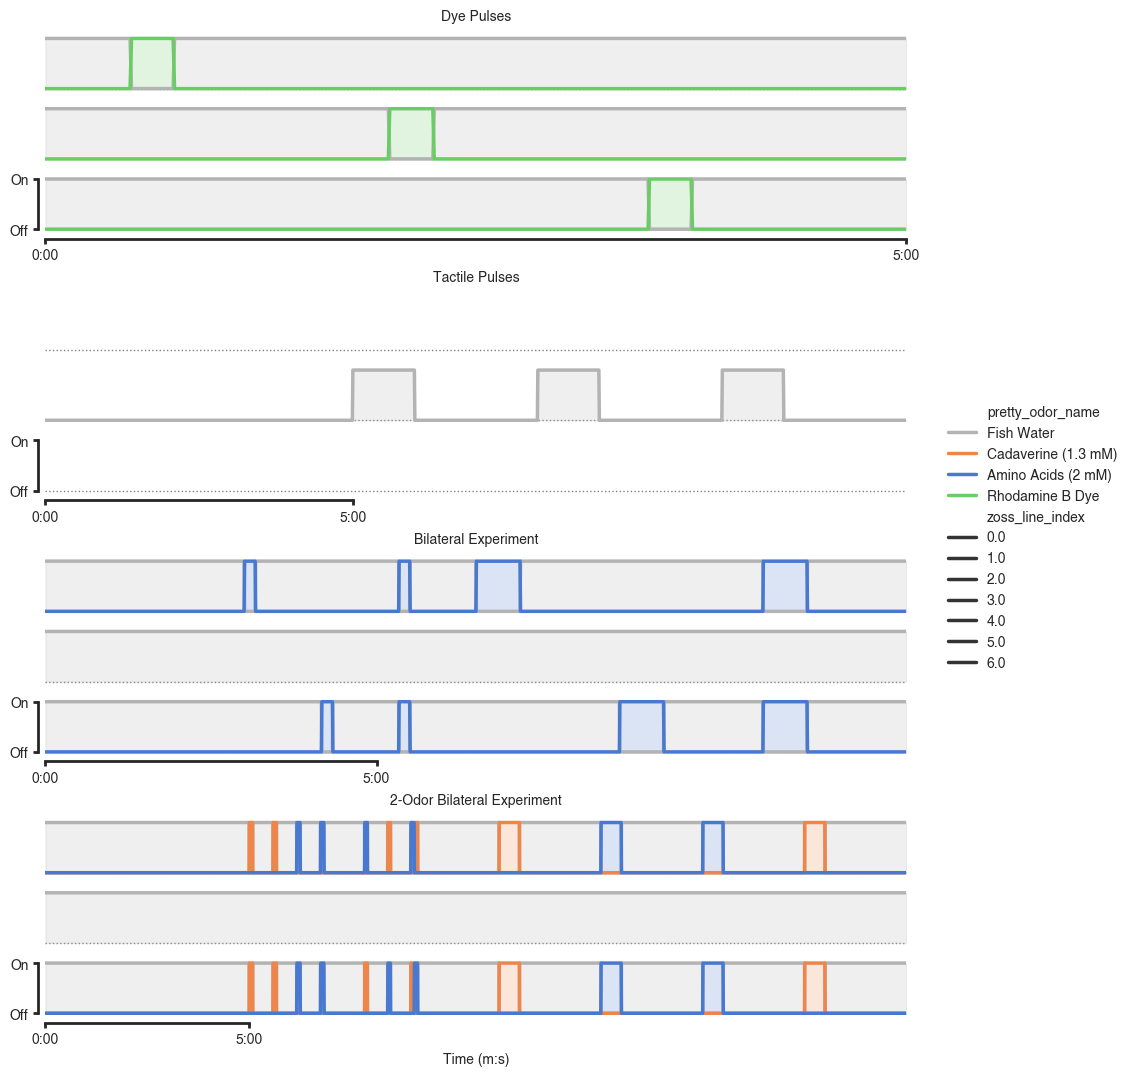

In [191]:
%matplotlib inline
for _, fig in plot_stim_status():
    fig.set(facecolor='white')
    plt.show()

## Save All Figures

In [192]:
all_figs = it.chain(
    plot_stim_status(),
)

output_dir = (r'G:\c_swain\zf_correlative_microscopy'
              r'\analyzed_and_generated_data\multi_experiment_figures')
output_dir = os.path.join(output_dir, 'stimulation_sequence_overview')

csutils.touchdir(output_dir)

overwrite = True # <<<<<<<<<<<<<<< FALSE (only change temporarily)

for fig_name, fig in all_figs:
    for ext in ('png', 'pdf'):
        fig_path = os.path.join(
            output_dir, 
            f'{ext.upper()}s', 
            f'{fig_name}.{ext}')
        csutils.touchdir(os.path.dirname(fig_path))
        if not os.path.exists(fig_path) or overwrite:
            log.info(f'Saving figure "{os.path.basename(fig_path)}"...')
            fig.savefig(
                fig_path, dpi=300,
                bbox_inches='tight', pad_inches=0.25)
    plt.close(fig)

local-nb_cs-ii-31_stim_sequences (  21): INFO : Saving figure "stimulus_experiment_overview.png"...
local-nb_cs-ii-31_stim_sequences (  21): INFO : Saving figure "stimulus_experiment_overview.pdf"...
matplotlib.backends.backend_pdf ( 918): DEBUG : Assigning font /F1 = 'C:\\Windows\\Fonts\\Linotype - HelveticaLTPro-Roman.otf'
matplotlib.backends.backend_pdf ( 964): DEBUG : Embedding font C:\Windows\Fonts\Linotype - HelveticaLTPro-Roman.otf.
matplotlib.backends.backend_pdf ( 971): DEBUG : Writing TrueType font.
